<a href="https://colab.research.google.com/github/Deep-Poets-Society/Deep-Comedy/blob/beam_search/generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google Colab Setup

import sys
import os

%cd /content
!rm -rf Deep-Comedy &> /dev/null
!git clone https://github.com/Deep-Poets-Society/Deep-Comedy &> /dev/null
%cd Deep-Comedy

sys.path.append(os.getcwd())

!pip install tensorflow &> /dev/null
!pip install tensorflow_text &> /dev/null

/content
/content/Deep-Comedy


In [2]:
from tokenizer import Tokenizer
import tensorflow as tf
import time
import numpy as np
import re
from matplotlib import pyplot as plt
from utils import load_dataset_for_gen, positional_encoding, loss_function, accuracy_function, plot_accuracy
from models import Transformer, create_masks
from schedules import CustomSchedule
from preprocessing import CESURA, SPACE, SYL, NEW_LINE
import random

In [3]:
dataset = load_dataset_for_gen()
train = dataset['train']
val = dataset['val']

In [4]:
tokenizer = Tokenizer(['[START]', '[END]', f'{SPACE}', f'{NEW_LINE}'], 'res/vocab_gen.txt')

In [5]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [6]:
def tokenize_pairs(X, y):
    X = tokenizer.tokenize(X)
    # Convert from ragged to dense, padding with zeros.
    X = X.to_tensor()

    y = tokenizer.tokenize(y)
    # Convert from ragged to dense, padding with zeros.
    y = y.to_tensor()

    return X, y


def make_batches(ds):
    return (ds
            .cache()
            .shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE)
            .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE)
            )

In [7]:
train_batches = make_batches(train)
val_batches = make_batches(val)

Hyperparameters

In [8]:
num_layers = 4
d_model = 256
dff = 1024
num_heads = 8
dropout_rate = 0.1

Set Adam Optimizer

In [9]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Loss and metrics

In [10]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')

Training and checkpoint


In [11]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizer.get_vocab_size().numpy(),
    target_vocab_size=tokenizer.get_vocab_size().numpy(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [84]:
checkpoint_path = "./checkpoints-gen/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [83]:
EPOCHS = 100

In [79]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [80]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [85]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  # inp -> X, tar -> y
  for (batch, entry) in enumerate(train_batches):
    inp = entry[0]
    tar = entry[1]
    train_step(inp, tar)

    #if batch % 50 == 0:
    #  print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
  
  for val_entry in val_batches:
    val_inp = val_entry[0]
    val_tar = val_entry[1]
    val_tar_inp = val_tar[:, :-1]
    val_tar_real = val_tar[:, 1:]
    with tf.GradientTape() as tape:
      predictions, _ = transformer([val_inp, val_tar_inp],
                                 training = False)
    loss = loss_function(val_tar_real, predictions)
    val_loss(loss)
    val_accuracy(accuracy_function(val_tar_real, predictions))
  
  print(f'Epoch {epoch + 1} Train loss {train_loss.result():.4f} Train accuracy {train_accuracy.result():.4f}')
  print(f'Epoch {epoch + 1} Validation loss {val_loss.result():.4f} Validation accuracy {val_accuracy.result():.4f}')

  train_losses.append(train_loss.result().numpy())
  train_accuracies.append(train_accuracy.result().numpy())
  val_losses.append(val_loss.result().numpy())
  val_accuracies.append(val_accuracy.result().numpy())

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Train loss 0.6732 Train accuracy 0.7995
Epoch 1 Validation loss 1.9788 Validation accuracy 0.6072
Time taken for 1 epoch: 15.04 secs

Epoch 2 Train loss 0.6538 Train accuracy 0.8044
Epoch 2 Validation loss 2.0340 Validation accuracy 0.6049
Time taken for 1 epoch: 15.09 secs

Epoch 3 Train loss 0.6358 Train accuracy 0.8089
Epoch 3 Validation loss 2.0705 Validation accuracy 0.6024
Time taken for 1 epoch: 15.24 secs

Epoch 4 Train loss 0.6217 Train accuracy 0.8123
Epoch 4 Validation loss 2.0937 Validation accuracy 0.6037
Time taken for 1 epoch: 15.33 secs

Saving checkpoint for epoch 5 at ./checkpoints-gen/train/ckpt-15
Epoch 5 Train loss 0.6051 Train accuracy 0.8160
Epoch 5 Validation loss 2.1046 Validation accuracy 0.5988
Time taken for 1 epoch: 15.86 secs

Epoch 6 Train loss 0.5861 Train accuracy 0.8215
Epoch 6 Validation loss 2.1526 Validation accuracy 0.5956
Time taken for 1 epoch: 15.49 secs

Epoch 7 Train loss 0.5741 Train accuracy 0.8247
Epoch 7 Validation loss 2.1496 Vali

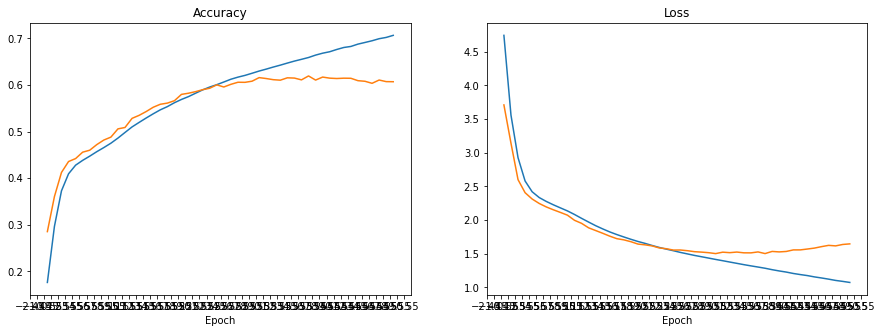

In [17]:
plot_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

Evaluate

In [18]:
def add_randomness(arr, r):
  rand_arr = [1.0 + random.uniform(-r, r) for _ in arr]
  rand_arr = np.array(rand_arr, dtype = float)
  return np.multiply(arr, rand_arr)

In [19]:
def beam_search(line, max_length=1000, beam_width=10, random_factor=0.1):
  line = tf.convert_to_tensor([line])
  encoder_input = tokenizer.tokenize(line).to_tensor()

  start, end = tokenizer.tokenize([''])[0]
  output = tf.convert_to_tensor([start])
  output = tf.expand_dims(output, 0)

  # predictions.shape == (batch_size, seq_len, vocab_size)
  predictions, attention_weights = transformer.call((encoder_input, output),
                                              False)
  predictions = tf.nn.softmax(predictions, axis=-1)
  # select the last word from the seq_len dimension
  predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
  predictions = add_randomness(predictions.numpy()[0][0], random_factor) 
  predictions = np.log(predictions)
  tokens = np.argpartition(predictions, -beam_width)[-beam_width:]
  probabilities = predictions[tokens]
  beams = []
  for token in tokens:
    token = tf.convert_to_tensor([token], dtype=tf.int64)
    token = tf.expand_dims(token, 0)
    beams.append(tf.concat([output, token], axis=-1))

  for j in range(max_length-1):
    candidates = []
    candidates_probs = []
    is_all_ended = True
    for k, beam in enumerate(beams):
      if beam.numpy()[0][-1] != end:
        is_all_ended = False
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer.call((encoder_input, beam),
                                                    False)
        predictions = tf.nn.softmax(predictions, axis=-1)
        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
        predictions = add_randomness(predictions.numpy()[0][0], random_factor) 
        predictions = np.log(predictions)
        indeces = np.argpartition(predictions, -beam_width)[-beam_width:]
        values = predictions[indeces] + probabilities[k]
        for index, prob in zip(indeces, values):
          index = tf.convert_to_tensor([index], dtype=tf.int64)
          index = tf.expand_dims(index, 0)
          candidates.append(tf.concat([beam, index], axis=-1))
          candidates_probs.append(prob)
      else:
        text = tokenizer.detokenize(beam)[0]
        tokens = tokenizer.lookup(beam)[0]
        return text, tokens, attention_weights
    print(tokenizer.detokenize(beams[0])[0].numpy().decode('utf-8'))
    if is_all_ended:
      break
    best_probs = np.argpartition(candidates_probs, -beam_width)[-beam_width:]
    for i, prob in enumerate(best_probs):
      if beams[i].numpy()[0][-1] != end:
        beams[i] = candidates[prob]
        probabilities[i] = candidates_probs[prob]

  text = tokenizer.detokenize(beams[0])[0]
  tokens = tokenizer.lookup(beams[0])[0]
  return text, tokens, attention_weights
  

In [64]:
def top_k(line, max_length=1000, k=1, r=1.0):
  '''
  Parameters
  ----------
  line : str
      The input line
  max_length : int, optional
      The max length in tokens of the output string (default is 1000)
  k : int, optional
      The parameter k of top-k sampling, with 1 the function behaves as a
      standard greedy selection (default is 1)
  r : float, optional
      sampling is applied with probability r, so with r=0.0 the function behaves
      as a standard greedy selection, with r=1.0 as a standard top-k sampling
      (default is 1.0)
  '''
  line = tf.convert_to_tensor([line])
  line = tokenizer.tokenize(line).to_tensor()

  encoder_input = line

  start, end = tokenizer.tokenize([''])[0]
  output = tf.convert_to_tensor([start])
  output = tf.expand_dims(output, 0)

  for i in range(max_length):
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer.call((encoder_input, output),
                                                 False)
    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
    if i > 0 and random.random() < r:
      predictions = tf.nn.softmax(predictions, axis=-1)
      top = tf.math.top_k(predictions.numpy()[0][0], k=k)
      predicted_id = random.choices(top.indices.numpy(), weights=top.values.numpy(), k=1)
      predicted_id = tf.convert_to_tensor([predicted_id], dtype=tf.int64)
    else:
      predicted_id = tf.argmax(predictions, axis=-1)
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)
    # return the result if the predicted_id is equal to the end token
    if predicted_id == end:
      break

  # output.shape (1, tokens)
  text = tokenizer.detokenize(output)[0]
  tokens = tokenizer.lookup(output)[0]
  return text, tokens, attention_weights

In [52]:
def print_prediction(x, true=None, add_spaces=True):
  if true is None:
    true = 'Not provided\n'

  if add_spaces:
    x = re.sub(' ', ' S ', x)
  
  predicted, _, _ = top_k(x)
  predicted = predicted.numpy().decode('utf-8')
  x = re.sub(' S ', ' ', x)
  print(f'Original:\n{x}\n')
  print(f'Predicted:\n{predicted}\n')
  print(f'True:\n{true}\n')
  print('#'*50)

In [ ]:
test = dataset['test']
for batch, (x, y) in enumerate(test.batch(1)):
  if batch > 0:
    x = x.numpy()[0].decode('utf-8')
    y = y.numpy()[0].decode('utf-8')
    print_prediction(x, y, add_spaces=False)
    if batch >=10:
      break

In [86]:
test = dataset['test']
pick = random.randint(0,20)
tercets = random.randint(10, 10)
for i, (x, y) in enumerate(test.batch(1)):
  if i == pick:
    seed = x.numpy()[0].decode('utf-8')
    break
print('seed:\n' + re.sub(' S ', ' ', re.sub(' N ', '\n ', seed)) + '\n')
print('---generated:---\n')
for i in range(tercets):
  predicted, _, _ = top_k(seed, k=2, r=0.5)
  predicted = predicted.numpy().decode('utf-8')
  predicted = re.sub('[|$]', '', predicted)
  print(predicted + '\n')
  x = re.sub('[|$]', '', re.sub(r'\n', ' N ', re.sub(' ', ' S ', predicted)))

seed:
 quale sovresso il nido si rigira
 poi c’ ha pasciuti la cicogna i figli
 e come quel ch’ è pasto la rimira 

---generated:---

e ciò che potea non potea men duca
rispuose a li altri non son li lori
ma io fui ma tal de li stegni leca

ma come l’ anima che di fuggegna
in su le strappa sì com’ io li scale
uno suoi piangere e con pausagna

e come i legni che di noi pareva
per lo segno suo passo fuor d’ i mola
che faceva strada di città schiva

e come l’ uom ch’ erano intorno lati
per lo segne del ciel vero stremo
che non potea col petto non t’ assili

e come l’ una e l’ altra novellage
per la sua spera di cagna in suso
che fece parlare o avrei s’ impage

e come l’ una e l’ altra novellava
per la sua spera che caccia per croce
un’ altra cosa i figliuoli le strava

e come l’ una e l’ altra nostra porta
per un duca mio di che fuor la pece
uno intendenza come non si porta

e come l’ uno e l’ altro insieme polo
che fa rivenò di te mi pareva
sì che la viva lunga mi ristelo

e come l’ una 